# Setup

In [1]:
import os

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import nltk
import string
import re
from nltk import word_tokenize, FreqDist,regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer,PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
from sklearn.cluster import AgglomerativeClustering, KMeans, AffinityPropagation
from sklearn.cluster import DBSCAN, OPTICS,MeanShift
from scipy.cluster.hierarchy import dendrogram,linkage

In [5]:
from bs4 import BeautifulSoup as bs
from itertools import takewhile
import requests
import json

In [113]:
%run Code/Functionality.py
Universe['Sector']=Universe.index.map(lambda t:retrieve_co_info(t)[0][:-1])
Universe['Industry']=Universe.index.map(lambda t:retrieve_co_info(t)[1][:-1])

In [116]:
#To save on execution time, I have loaded up some of the corpa that will be used frequently.
corpus_all=collect_texts_all()
corpus_2020=collect_texts_year('2020')
corpus_2019=collect_texts_year('2019')
corpus_2018=collect_texts_year('2018')
corpus_2017=collect_texts_year('2017')
corpus_2016=collect_texts_year('2016')

In [105]:
__SKIP_IMAGING__=TRUE #Needed to run notebook quickly.

# EDA

### Time Horizon
The database of risk disclosures we have built is pretty evenly distributed across the last ten years.  As we can see below, we have a sizable number of companies with at least three years of history, a sizable dropoff in the number with at least five years of history and another sizeable dropoff in the number with a complete ten-year history.

In [43]:
print(len(Filed))
Filed[coverage].apply(sum)

151


2011     67
2012     84
2013     90
2014    107
2015    118
2016    123
2017    129
2018    135
2019    143
2020    149
dtype: int64

# EDA-Traditional (Discrete) Bucketing
## By Sector & Industry (per Yahoo Finance)
The bulk of our universe is made up of TMT (Tech, Media & Telecom) companies (Tech & Communication Services, below) with the addition of consumer/retail tech companies (consumer cyclical) and technolgoy-adjacent/focused companies in other industries.

As can be seen in the industry count, we have a lot of software companies--e.g. Adobe--within tech; a lot of media within Comm. Services--e.g. CBS.  

In [8]:
Universe.Sector.value_counts()

Technology                59
Communication Services    52
Consumer Cyclical         22
Real Estate                6
Financial Services         6
Industrials                3
Consumer Defensive         2
Healthcare                 1
Name: Sector, dtype: int64

In [10]:
Universe.Industry.value_counts()

Software—Application                   20
Software—Infrastructure                15
Internet Content & Information         13
Entertainment                          10
Broadcasting                           10
Telecom Services                       10
Internet Retail                         9
Semiconductors                          7
Information Technology Services         5
Electronic Gaming & Multimedia          4
Specialty Retail                        4
REIT—Specialty                          4
Credit Services                         4
Advertising Agencies                    4
Consumer Electronics                    3
Computer Hardware                       3
Communication Equipment                 3
Travel Services                         3
Gambling                                2
Semiconductor Equipment & Materials     2
Furnishings, Fixtures & Appliances      2
REIT—Office                             2
Mortgage Finance                        2
Education & Training Services     

## SIC
With Sector and Industry classification, there is a certain amount of discretion for which bucket a company is most appropriate.  I have relied on Yahoo Finance but many other financial resource wil use their own, sometimes unique, classification system.

To get away from this subjectivity, it is useful to refer to SIC codes.  This system is less popular within traditional financial media but it is widely-used by government gencies, including the SEC, and is a more scientific and granular classification system with four different levels of specificity.  https://en.wikipedia.org/wiki/Standard_Industrial_Classification

In [44]:
Universe.SIC.apply(lambda s:str(s)[:2]).value_counts()

73    65
48    26
36    15
35     7
67     6
59     6
79     3
78     3
55     3
61     3
57     3
27     2
72     2
47     2
37     1
25     1
50     1
38     1
82     1
Name: SIC, dtype: int64

We can see above that a very significant majority of the universe comes from the major industry coded '73' which can be thought of discretionary services; code '48' refers to communications-related industries; and code '36' refers to equipment-related industrues.

Diving further, below we see that most of the '73' bucket comes from the group bode '7372'--"Services--Packaged Software"--and some from '7389'--"Services--Business Services".

In [45]:
Universe[Universe.SIC.apply(lambda s:str(s)[:2])=='73'].SIC.value_counts()

7372    27
7389    14
7370     8
7374     7
7311     3
7310     2
7371     1
7340     1
7320     1
7373     1
Name: SIC, dtype: int64

In [58]:
print(retrieve_sic_desc('7372')[0][229:])
print()
print(retrieve_sic_desc('7389')[0][232:])

Establishments primarily engaged in the design, development, and production of prepackaged computer software. Important products of this industry include operating, utility, and applications programs. Establishments of this industry may also provide services such as preparation of software documentation for the user-installation of software for the user; and training the user in the use of the software. Establishments primarily engaged in providing preparation of computer software documentation and installation of software on a contract or fee basis are classified in Industry 7379, and those engaged in training users in the use of computer software are classified in Industry 8243. Establishments primarily engaged in buying and selling prepackaged computer software are classified in Trade; those providing custom computer programming services are classified in Industry 7371; and those developing custom computer integrated systems are classified in Industry 7373.  Applications software, c

In [41]:
Universe[Universe.SIC.apply(lambda s:str(s)[0])!='7'].SIC.value_counts().head(5)

3674    7
4841    6
4813    6
6798    6
4832    6
Name: SIC, dtype: int64

Stock Price Correlations

'3674' is semicounductor companies (see desc. below); '4841' is cable; '4813' is Telephonic communications; and '6798' is for REITs which in this universe refers to real estate used for server farms, etc.

In [71]:
print(retrieve_sic_desc('3674')[0][290:])
print()
print(retrieve_sic_desc('4841')[0][289:])
print()
print(retrieve_sic_desc('4813')[0][289:])
print()
print(retrieve_sic_desc('6798')[0][240:])

 Establishments primarily engaged in manufacturing semiconductors and related solid- state devices. Important products of this industry are semiconductor diodes and stacks, including rectifiers, integrated microcircuits (semiconductor networks), transistors, solar cells, and light sensing and emitting semi-conductor (solid-state) devices.  Computer logic modules  Controlled rectifiers, solid-state  Diodes, solid state (germanium, silicon, etc.)  Fuel cells, solid-state  Gunn effect devices  Hall effect devices  Hybrid integrated circuits  Infrared sensors, solid-state  Laser diodes  Light emitting diodes  Light sensitive devices, solid-state  Magnetic bubble memory device  Magnetohydrodynamic (MHD) devices  Memories, solid-state  Metal oxide silicon (MOS) devices  Microcircuits, integrated (semiconductor)  Microprocessors  Modules, solid-state  Molecular devices, solid-state  Monolithic integrated circuits (solid-state)  Optical isolators  Parametric diodes  Photoconductive cells  Phot

# EDA--Correlations
## Heatmaps

Another approach for analyzing similarity is the traditional and ever-popular correlation matrix.  This is especially helpful for modeling puprposes (like portfolio optimization) as well as gaining some insight into market structure (as we will see further below).

In [11]:
daily_prices,abs_data,rel_data=collect_market_data(Universe.index)

/Users/george/opt/anaconda3/lib/python3.8/site-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'FYBR', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


Abovee, we have collected market prices and daily (log) changes for our universe of stocks.  We have also calculated a number of correlation matrices where each element represents a correlation metric between the stock in the respective row and the stock in the respective column.  The correlation matrices cover two different time periods: 1) over the entire shared trading period for the respective stock pair & 2) correlation over individual years.  Over each time period, one matrix meausures across absolute changes and the other adjusts for changes relative to a benchmark.

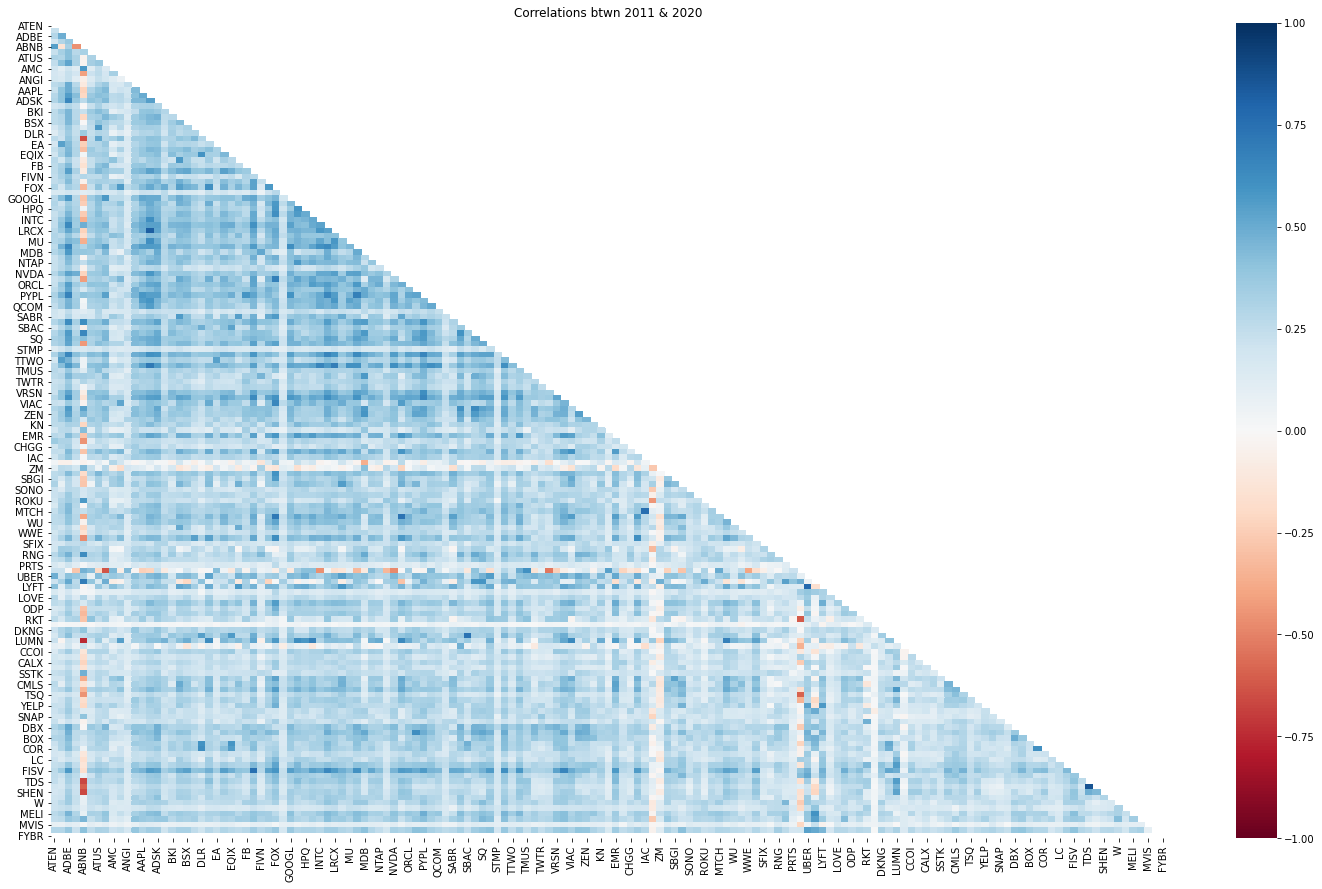

In [14]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(25,15))
ax.set_title('Correlations btwn 2011 & 2020')
mtrx=abs_data[1]
mask = np.zeros_like(mtrx)
mask[np.triu_indices_from(mtrx)] = True
sns.heatmap(mtrx,vmin=-1,vmax=1,cmap='RdBu',ax=ax,mask=mask);
ax.set_xlabel(None)
ax.set_ylabel(None)
fig.savefig(image_path+'Corr Matrix.pdf',
            orientation='landscape',
            pad_inches=0.0,bbox_inches='tight',
            format='pdf'
           )

As revealed by the amount of blue in the first heatmap, this universe moves fairly insync.


However, if we adjust for the overall market's movements (in this case, represented by the S&P 500 but any US benchmark--Russell, NYSE TMT, Willshire--show similar results) we get a better representation of how these stocks moved together, indpendent of changes related to the broader market....much less blue in the heatmap below.

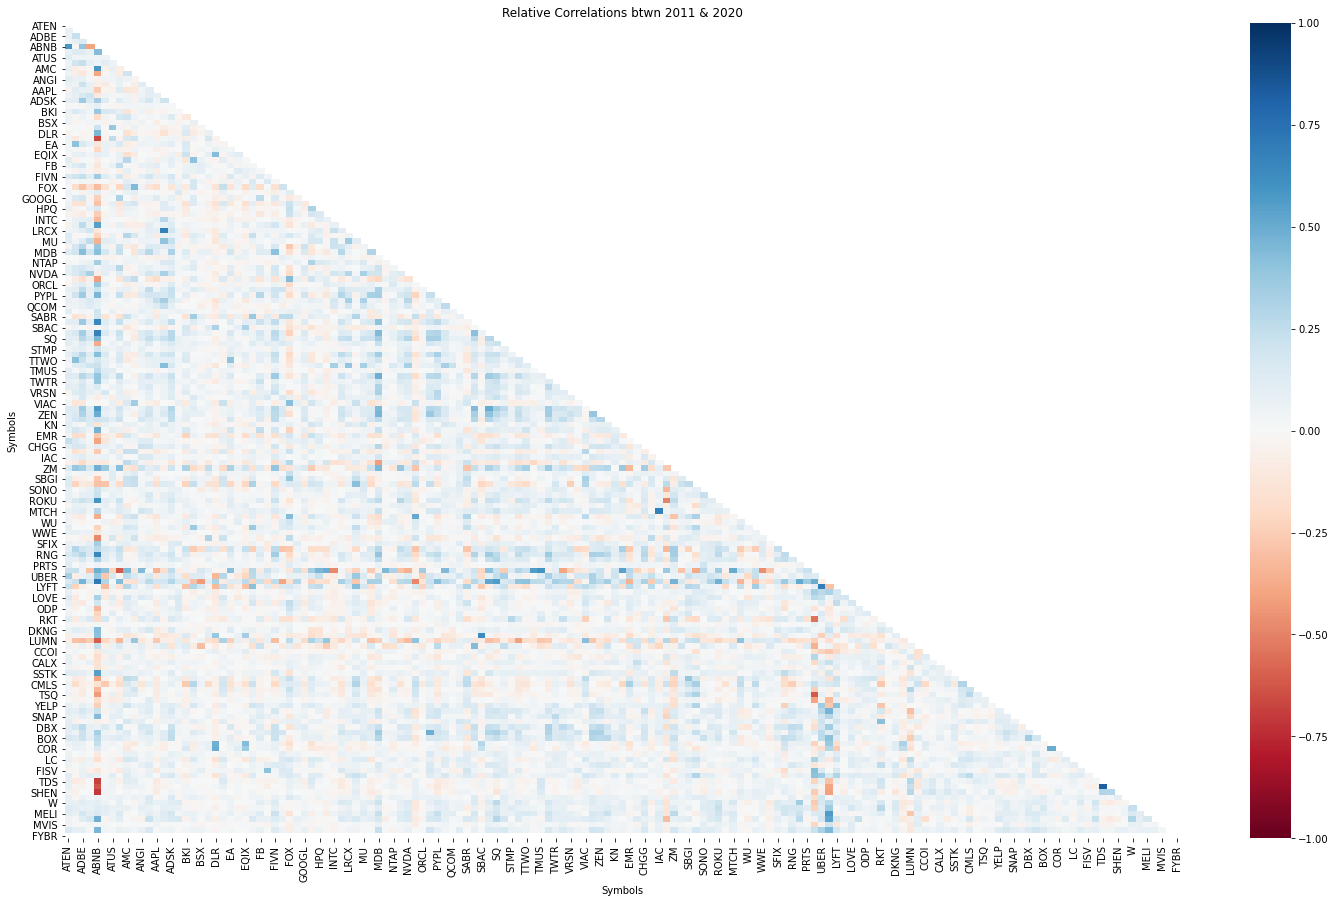

In [15]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(25,15))
ax.set_title('Relative Correlations btwn 2011 & 2020')
mtrx=rel_data[1]
mask = np.zeros_like(mtrx)
mask[np.triu_indices_from(mtrx)] = True
sns.heatmap(mtrx,vmin=-1,vmax=1,cmap='RdBu',ax=ax,mask=mask);
fig.savefig(image_path+'Corr Matrix_Relative.pdf',
            orientation='landscape',pad_inches=0.0,bbox_inches='tight',
            format='pdf'
           )

Looking at these relationships over the entire decade is interesting but there are a couple of issues: 1) the individual element of this heatmap represent correlations over broadly different time horizons, making stock-to-stock comparisons difficult (for instance, AirBnB, Uber & Lyft seem to have the strongest relationships with the rest of the universe but this is most likely attributed to their shorten trading periods); & 2) these correlation relationships definetly move around over a multi-year period for idiosyncratic and/or broad-based reasons--understanding these changes over time can offer much more insight into each stock.

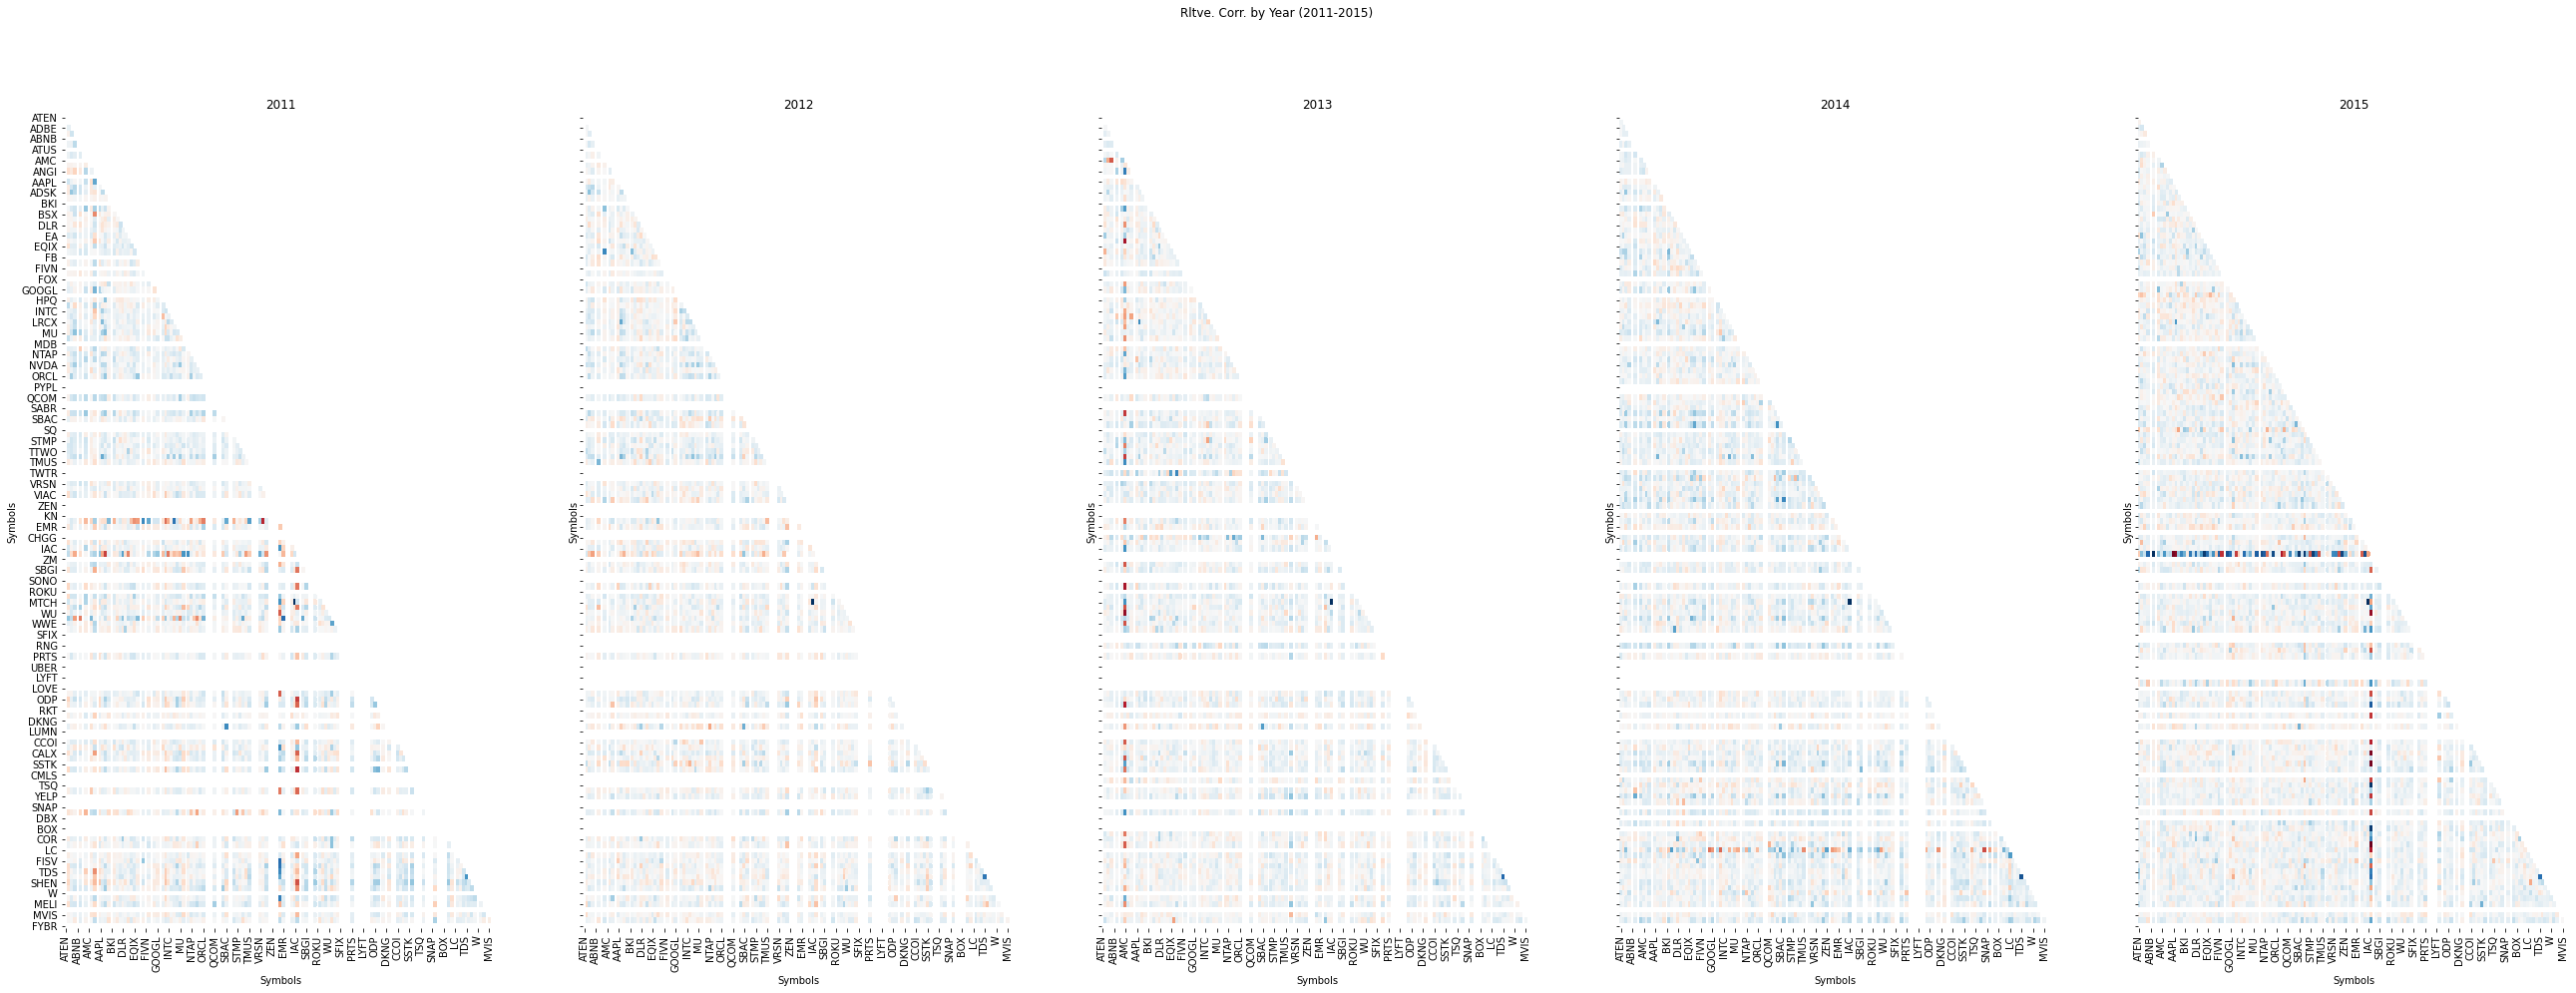

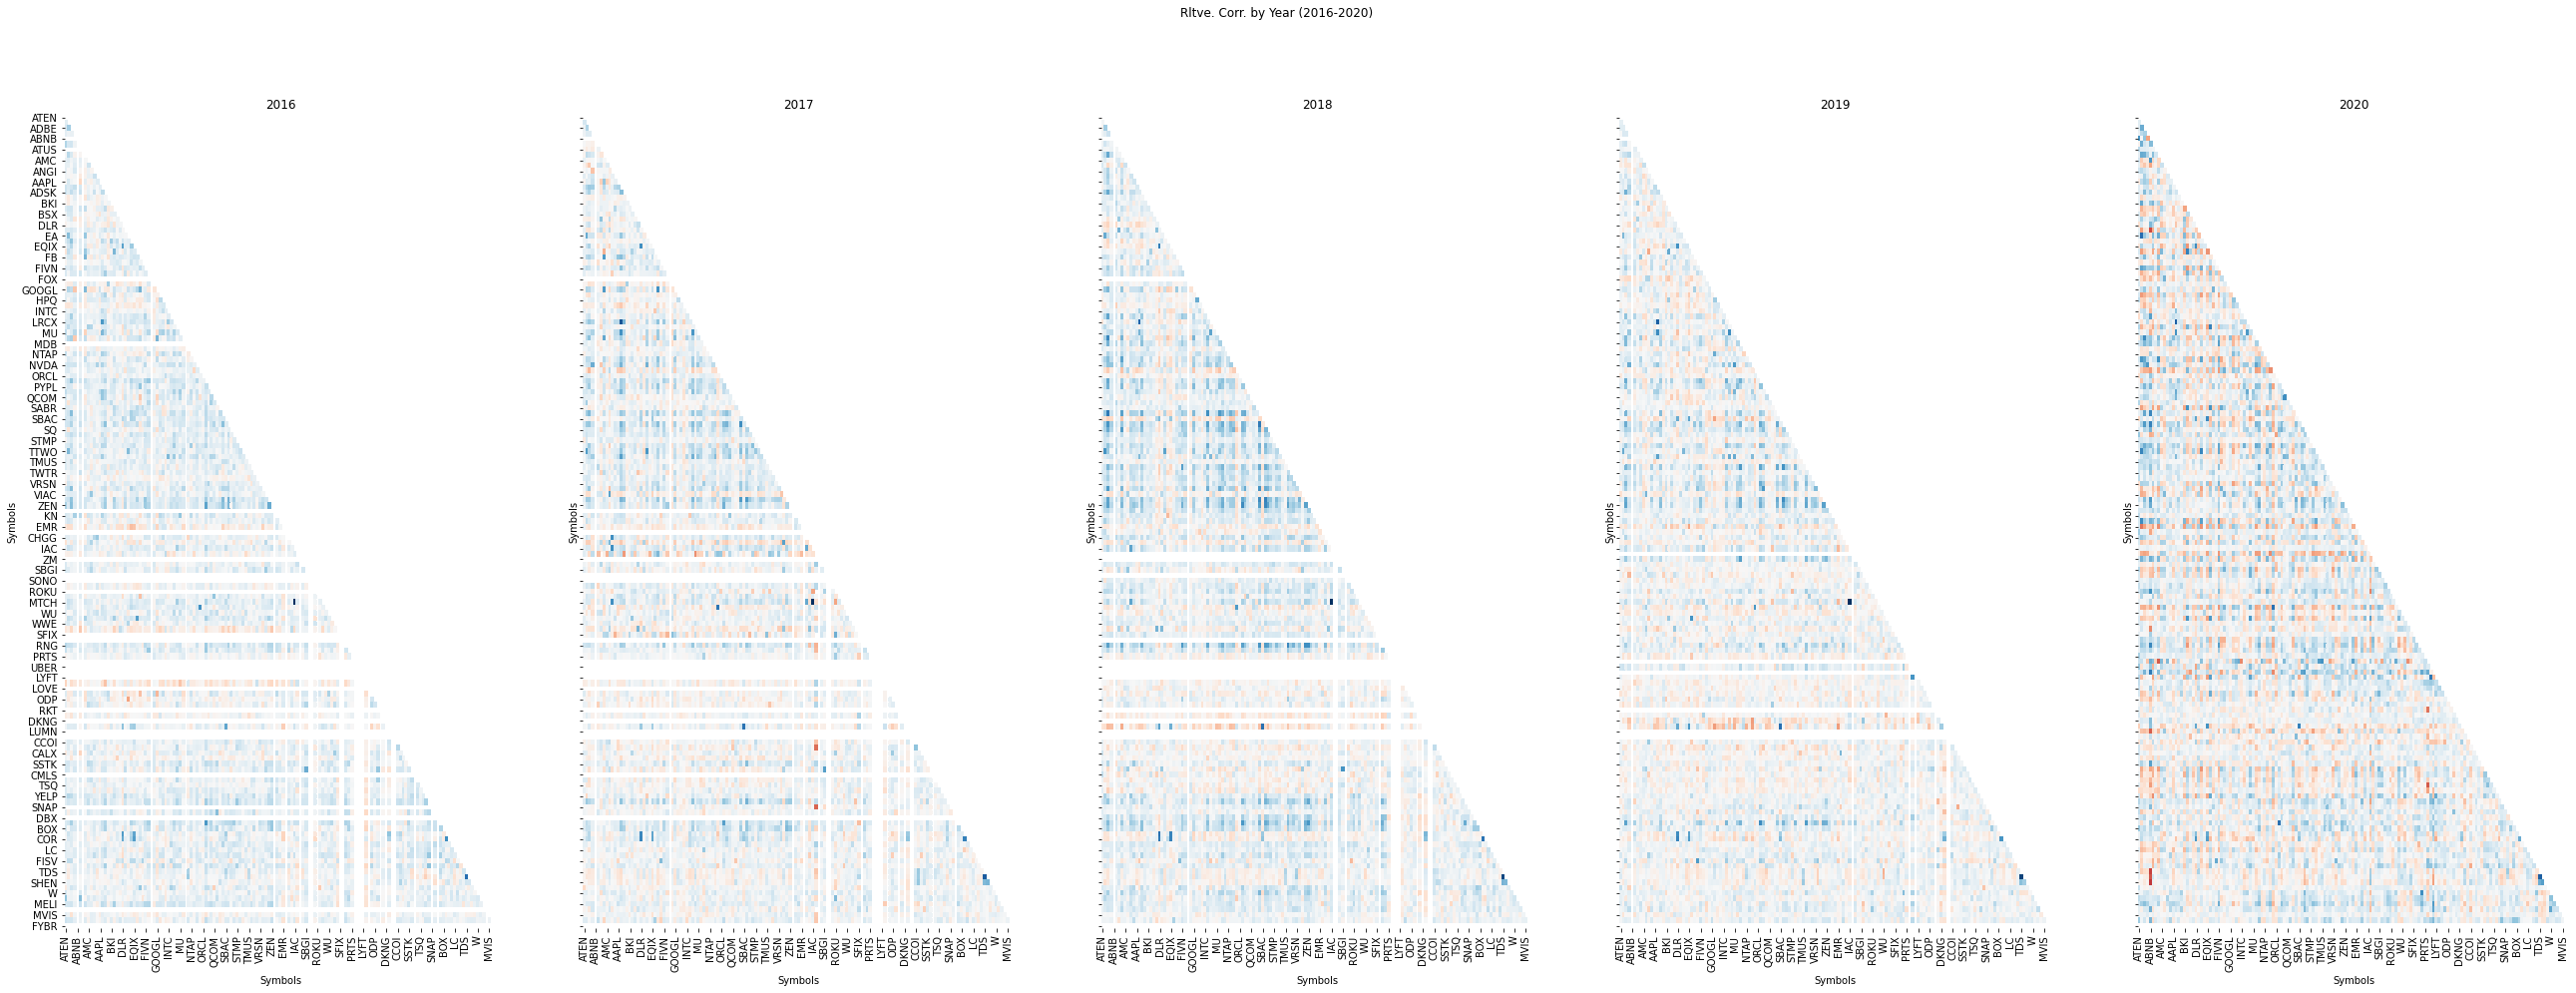

In [91]:
fig,ax=plt.subplots(ncols=5,nrows=1,figsize=(45,15),sharex=True,sharey=True,)
fig.suptitle('Rltve. Corr. by Year (2011-2015)')
axes=ax.reshape(-1)
i=0
for y in coverage[:5]:
    a=axes[i]
    a.set_title(y)
    corr_mat=rel_data[2].xs(y+'-12-31')
    mask = np.zeros_like(corr_mat)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr_mat,mask=mask,ax=a,vmin=-1,vmax=1,cbar=False,cmap='RdBu')
    i+=1
fig.savefig(image_path+'Annual Corr Matrices_Relative_I.pdf',
            orientation='landscape',
            pad_inches=0.0,
            bbox_inches='tight',
            format='pdf'
           )


fig,ax=plt.subplots(ncols=5,nrows=1,figsize=(45,15),sharex=True,sharey=True,)
fig.suptitle('Rltve. Corr. by Year (2016-2020)')
axes=ax.reshape(-1)
i=0
for y in coverage[5:]:
    a=axes[i]
    a.set_title(y)
    corr_mat=rel_data[2].xs(y+'-12-31')
    mask = np.zeros_like(corr_mat)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr_mat,mask=mask,ax=a,vmin=-1,vmax=1,cbar=False,cmap='RdBu')
    i+=1
fig.savefig(image_path+'Annual Corr Matrices_Relative_II.pdf',
            orientation='landscape',
            pad_inches=0.0,
            bbox_inches='tight',
            format='pdf'
           )

With some caveats, the side-by-side images provides some interesting insights.  For instance, this universe becomes gradually more correlated over time.  Generally, correlations have been positive--not surprising as the US market has generally moved closer together post-GFC--but the COVID-tainted year of 2020 saw a remarkably strong correlations BOTH positive and negative.  (Reminder that since these are changes relative to the benchmark, we are seeing idiosyncratic (partial) correlations.) There are also so notably individual blips in any given year that may be of interest.  For instance, AMC in 2013 & IAC in 2015.  AMC was taken over by a Chinese conglomerate in mid-2012 while IAC (a portfolio company) announced the public sale of its interest in Match.com.  

However, these heatmaps are still pretty noisy with the number of stocks in the Universe.  So let's look at some graphing techniques for additional insight:

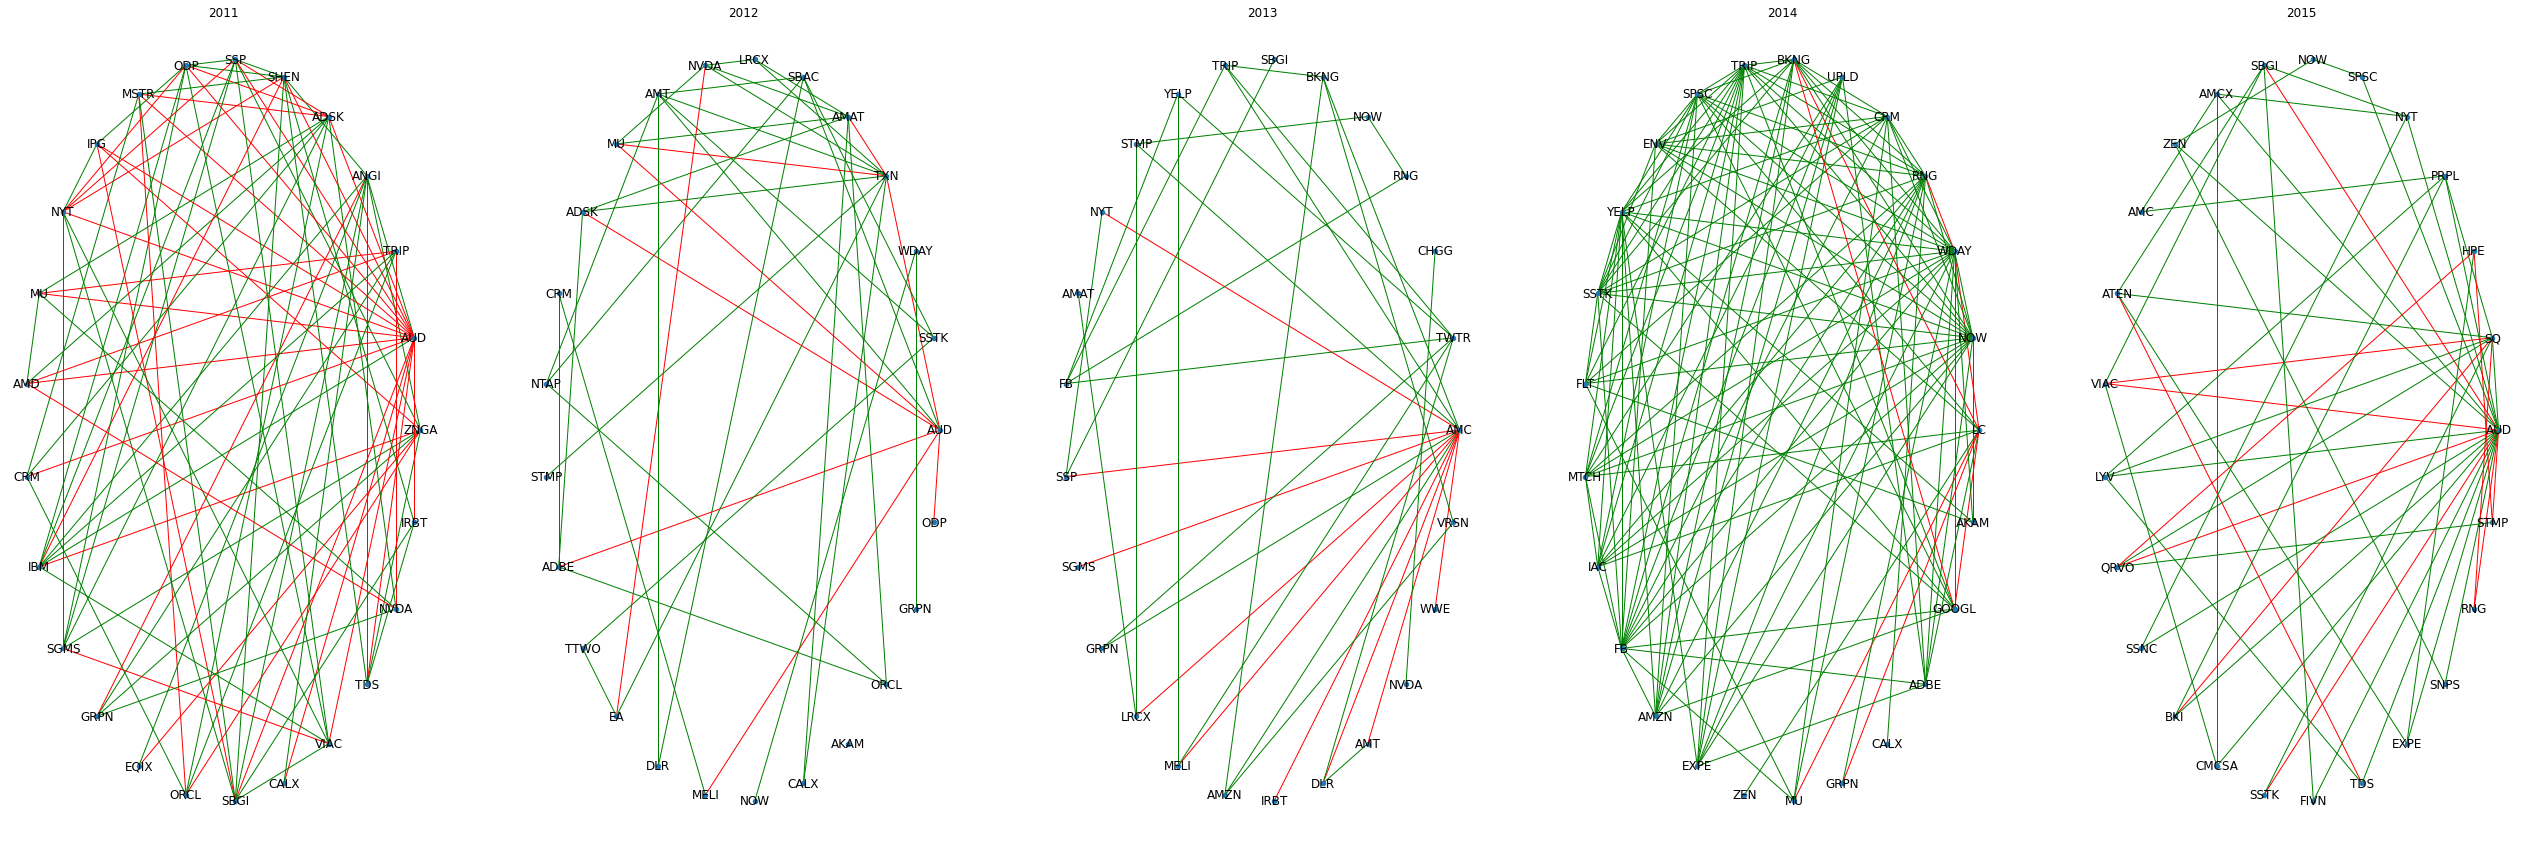

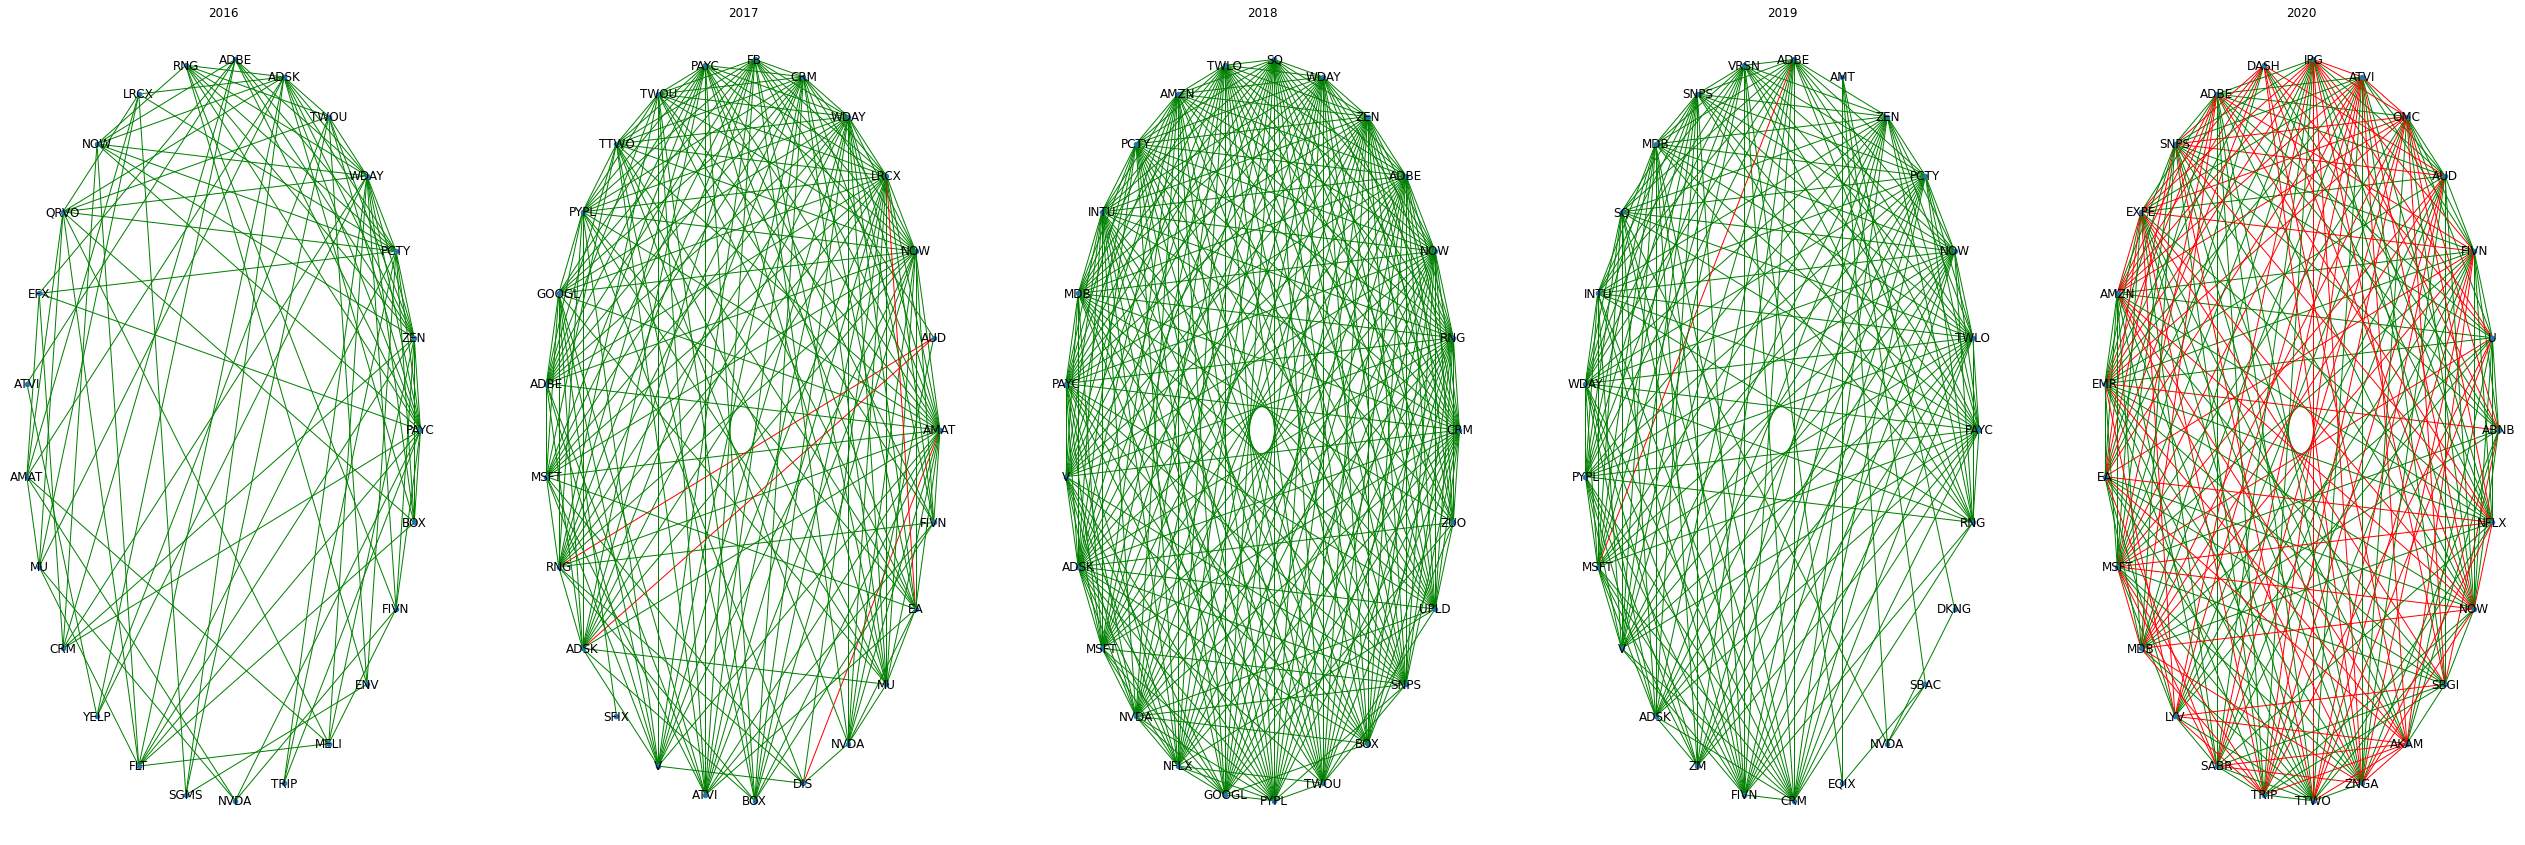

In [92]:
fig,axes=plt.subplots(ncols=5,nrows=1,figsize=(45,15))
axes=axes.reshape(-1)
matrix=rel_data[2]
i=0
for yr in coverage[:5]:
    Sigma=matrix.xs(yr+'-12-31')
    Tops=filter_rank(Sigma,25)
    G=graphx.Graph()
    G.add_nodes_from(Tops.index)
    colors=[]
    a=axes[i]
    a.set_title(yr)
    for tick_a in G.nodes:
        for tick_b in G.nodes:
            p=Sigma[tick_a][tick_b]
            if((tick_a!=tick_b) and abs(p)>0.25):
                clr='green' if p>0 else 'red'
                colors.append(clr)
                G.add_edge(tick_a,tick_b,color=clr,weight=abs(p))
            else:
                pass
                #print(tick_a,tick_b)
    graphx.draw_circular(G,with_labels=True,edge_color=colors,node_size=20,ax=a)
    i+=1
fig.savefig(image_path+'Annual Universe Structure_I.pdf',
            orientation='landscape',
            pad_inches=0.0,
            bbox_inches='tight',
            format='pdf'
           )


fig,axes=plt.subplots(ncols=5,nrows=1,figsize=(45,15))
axes=axes.reshape(-1)
matrix=rel_data[2]
i=0
for yr in coverage[5:]:
    Sigma=matrix.xs(yr+'-12-31')
    Tops=filter_rank(Sigma,25)
    G=graphx.Graph()
    G.add_nodes_from(Tops.index)
    colors=[]
    a=axes[i]
    a.set_title(yr)
    for tick_a in G.nodes:
        for tick_b in G.nodes:
            p=Sigma[tick_a][tick_b]
            if((tick_a!=tick_b) and abs(p)>0.25):
                clr='green' if p>0 else 'red'
                colors.append(clr)
                G.add_edge(tick_a,tick_b,color=clr,weight=abs(p))
            else:
                pass
                #print(tick_a,tick_b)
    graphx.draw_circular(G,with_labels=True,edge_color=colors,node_size=20,ax=a)
    i+=1
fig.savefig(image_path+'Annual Universe Structure_II.pdf',
            orientation='landscape',
            pad_inches=0.0,
            bbox_inches='tight',
            format='pdf'
           )

# EDA--Risk Disclosures & Text

The purpose of this project is to replace these traditional relationship definitions which are A) static and subjective (in the case of the qualitive classifications) or B) backward-looking and somewhat removed from the underlying business (in the case of correlations).

By analyzing risk disclosures, we hope to develop a way of categorizing companies which is forward-looking & dynamic over time while also (hopefully) making quick and reliable inferences easier.  

To see how this is possible, we can begin by simply looking at wordclouds which are easily quickly digestable, especially after some processing and engineering of the text.

In [114]:
#Creating & Storing wordcloud images
if __SKIP_IMAGING__:
    pass
else:
    for tick in Filed.index: visualize_stock(tick); # by company
    for yr in ['2016','2017','2018','2019','2020']: entire_year(yr); #by year
    #by Groups:
    visualize_group(sic_7372.Ticker,'Group 7372')
    visualize_group(sic_ex7.Ticker,'Group ex7372')
    visualize_group(sic_4.Ticker,'Group 4')
    visualize_group(sic_3.Ticker,'Group 3')
    visualize_group(sic_56.Ticker,'Groups 5+6')

## Company v. Company

Let's look at a comparison of the risk disclosures (combined across years) for three companies: Uber, Lyft & Doordash.

![Uber](./Images/Wordclouds/Combined/UBER.pdf)
![Lyft](./Images/Wordclouds/Combined/LYFT.pdf)
![DoorDash](./Images/Wordclouds/Combined/DASH.pdf)

Comparing the wordclouds (from left to right: Uber, Lyft and DoorDash) we can see some common and distringuishing features between the three internet companies.  All three have operations heavily relient on their platform but Uber's risk disclosure obviously has a lot of mentions of drivers which is not surprising as the company's relationship with its outsourced labor is a major question mark.  In Lyft, bike and scooter pop out more than driver--Lyft's hope to distinguish itself is through these non-traditional transportation modes--and in Dash, merchant and consumer are substituted in.

## Timelines
There is also some interesting information from looking at disclousre changes over time for a single company:

Below is Amazon's risk disclosures over the past decade (left to right).
![Amazon Timeline](./Images/Wordclouds/Timeline/AMZN.pdf)

We can see two patterns: the increasing mention of taxes (as the comapny moved toward profitability) and the relative focus of customer vs service over time--attributable to the growing size of the company's AWS business.

In the case of Apple (below), a similar pattern emerges except it is from hardware-related vocab (like product and component) to services.  The shift is a bit more pronounced than in the case of Amazon and, unlike AWS, the shift coincides with a strategic change within Apple, recognizing the cheaper competition in hardware (ie phones) required them to develop a moat/ecosystem with high-quality software business lines--like the App Store--as covered in this USA Today [article](https://www.usatoday.com/story/tech/columnist/2017/05/01/apple-making-good-steve-jobs-vision-services/100786362/) from 2017. 



![Apple Timeline](./Images/Wordclouds/Timeline/AAPL.pdf)

Finally, if we look at Facebook over time (going back to 2012), we can see how mobile concerns faded away:

![Facebook Timeline](./Images/Wordclouds/Timeline/FB.pdf)

Consistently, Facebook's core business is about the product it can put provide to advertisors (or "advertising" in the text) and users.  But as documented in this [article](https://www.vox.com/2019/4/29/18511534/facebook-mobile-phone-f8), Facebook's early years as a pulbic company were significantly marred by the lack of traction in mobile activity.

Furthermore, we can see two new keywords pop up in the past few years:  "third party" and "content".

# Clustering Exploration

Assuming there is some information to be gleaned from a textual analysis of risk disclosures for different companies over time, we can extract quantitative features from the text which can be then used for independent clustering.  However, there are a number of different ways to go about this two-part process.  Let's explore some these options to get an idea of what is ultimately the best fit for our purpose (or purposes).

## Feature Engineering Step

I believe that a TfIdf vectorizor is the best approach given the number of keywords that are routinely used in the (sometimes boilerplate) risk disclosures.  So let's begin with the optional parameter settings for this vectorizor.  Note: we will be using a single corpus (all RDs from 202) and agglomerative clustering (clusters=20).

In [115]:
corpus=corpus_2020
Agg=AgglomerativeClustering(n_clusters=20)

### Max Features

In [117]:
#Creating vectorizers with different values for the max features parameter.
engineers={}
for n in [10,26,50,100,200,500,1000,1500,2000,5000]:
    parms={'max_df':0.95,'max_features':n,'min_df':0.05}
    engineers[str(n)]=create_extractor(corpus.values(),parms,'maxfeatures'+str(n))

For each engineer, 1) a dendrogram is created; 2) the clusterer is fit; 3) the results are saved out.

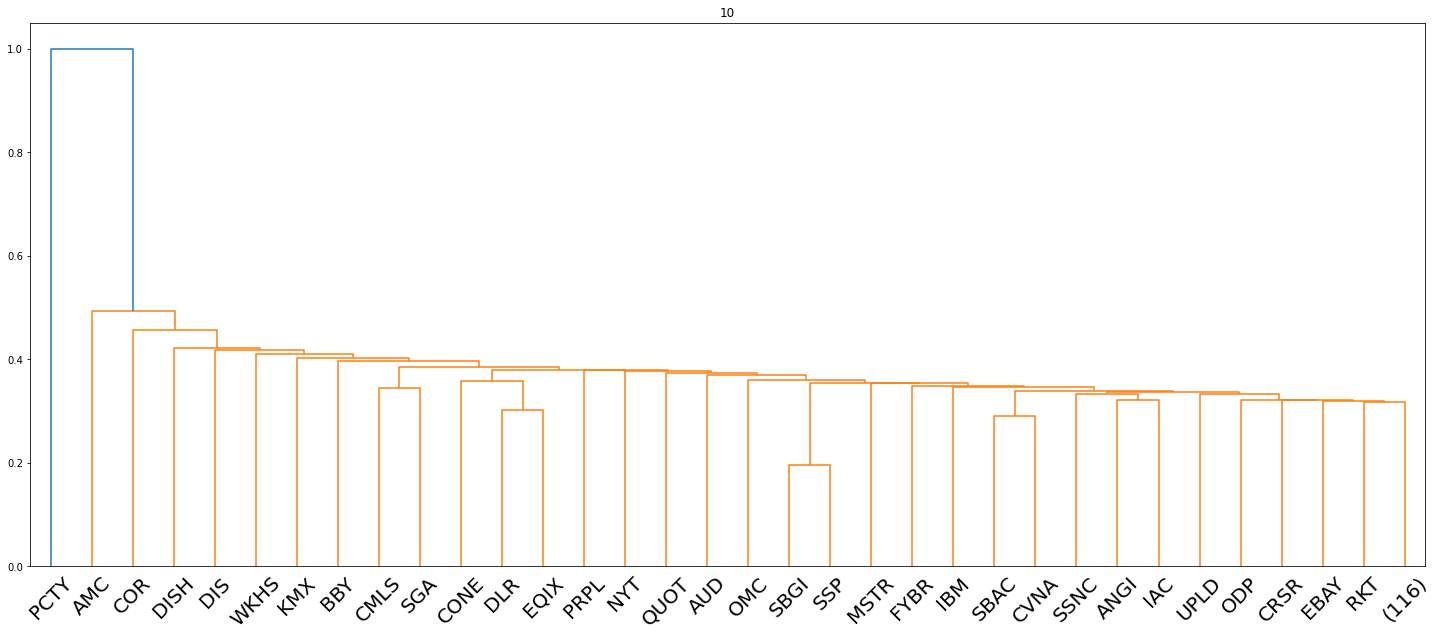

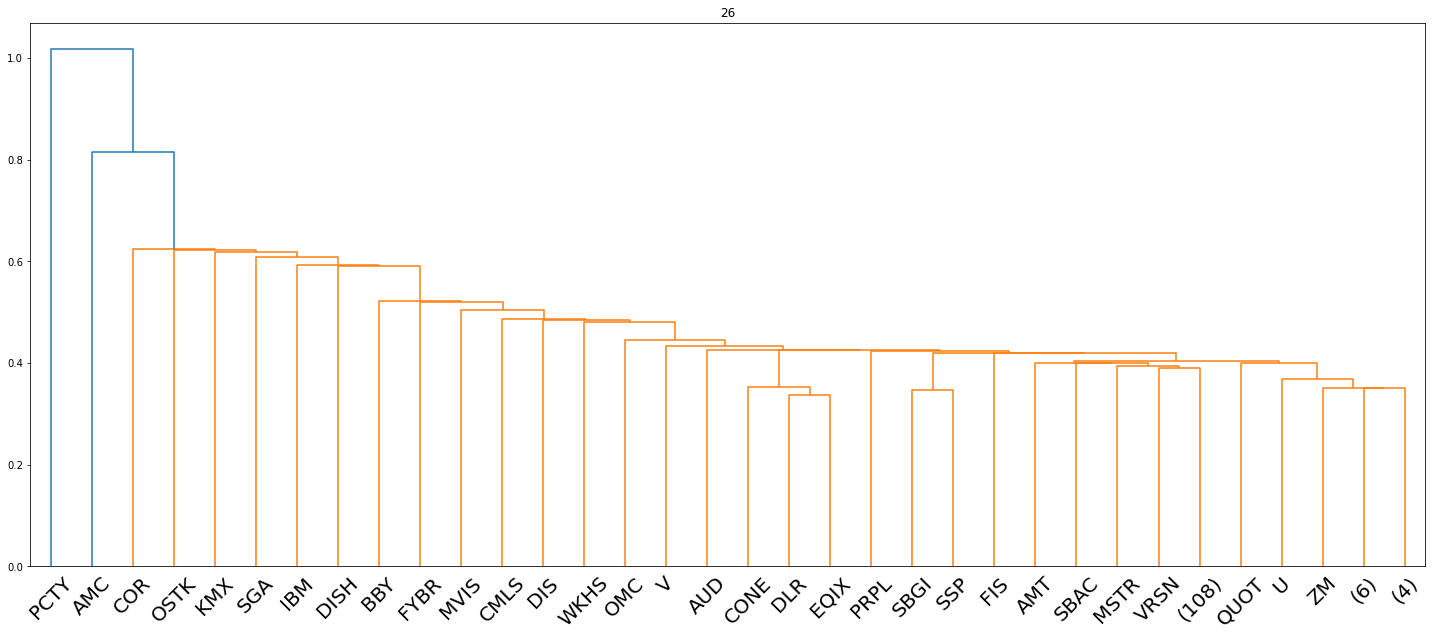

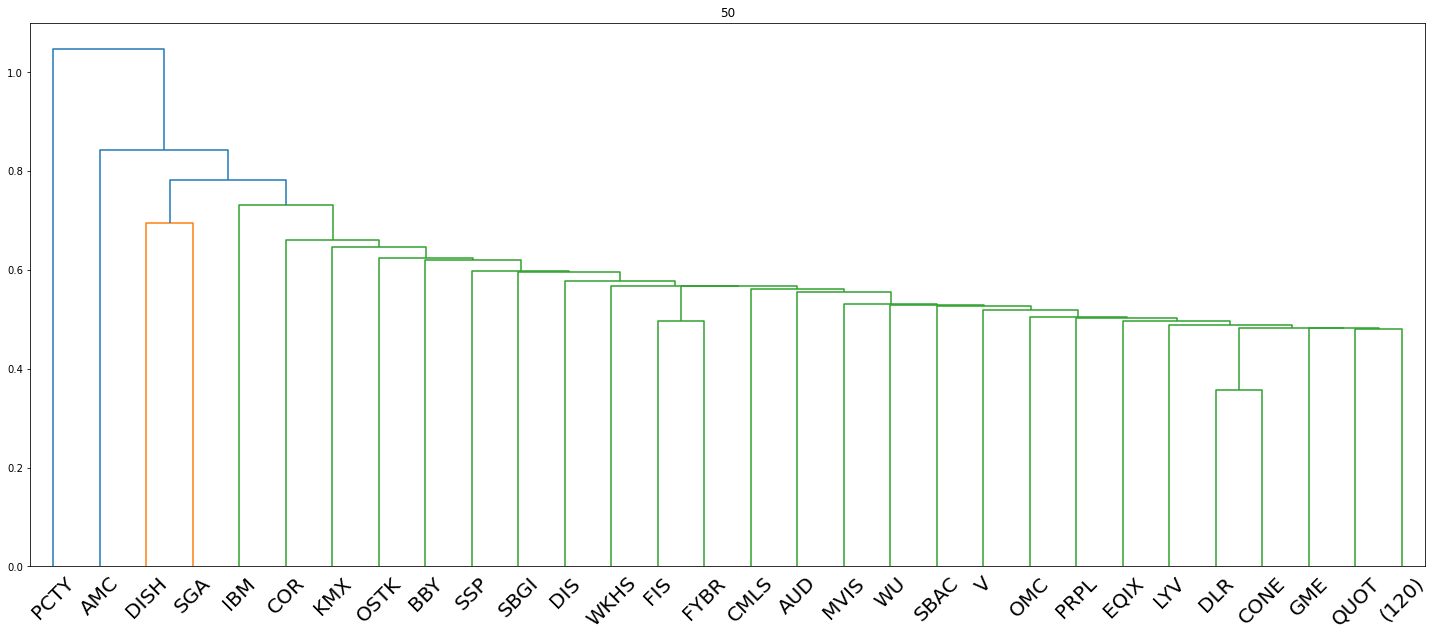

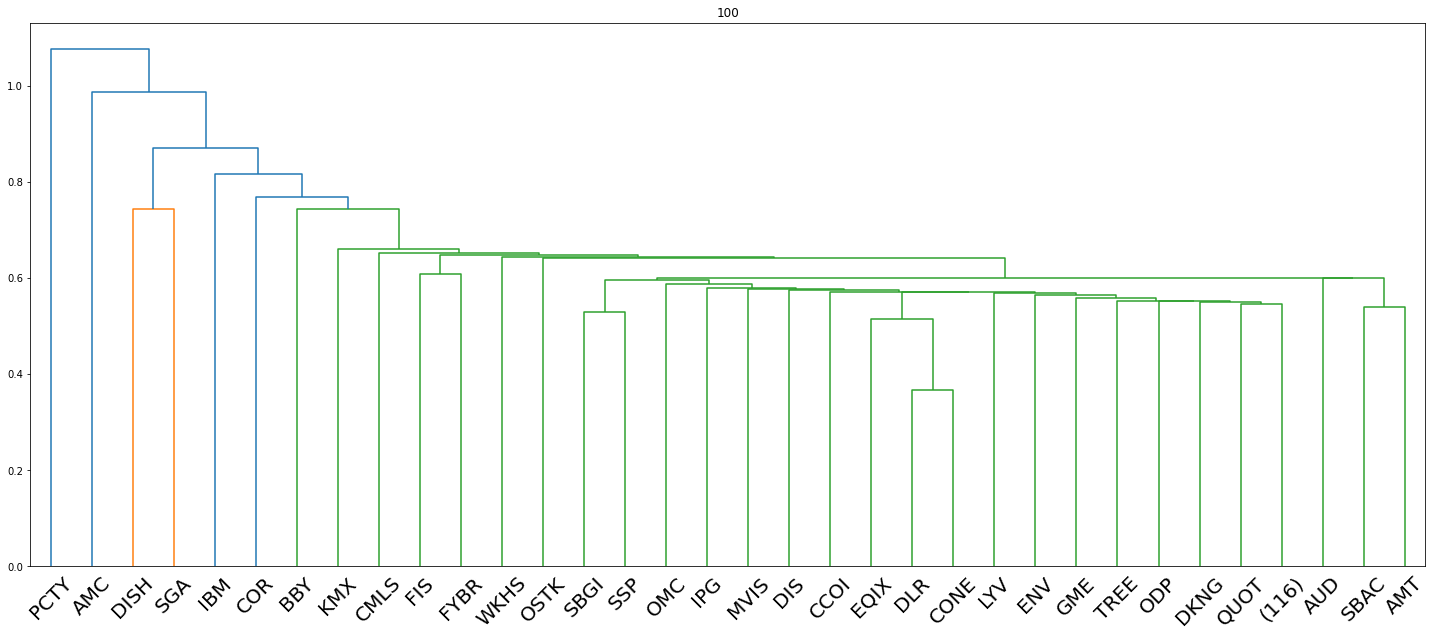

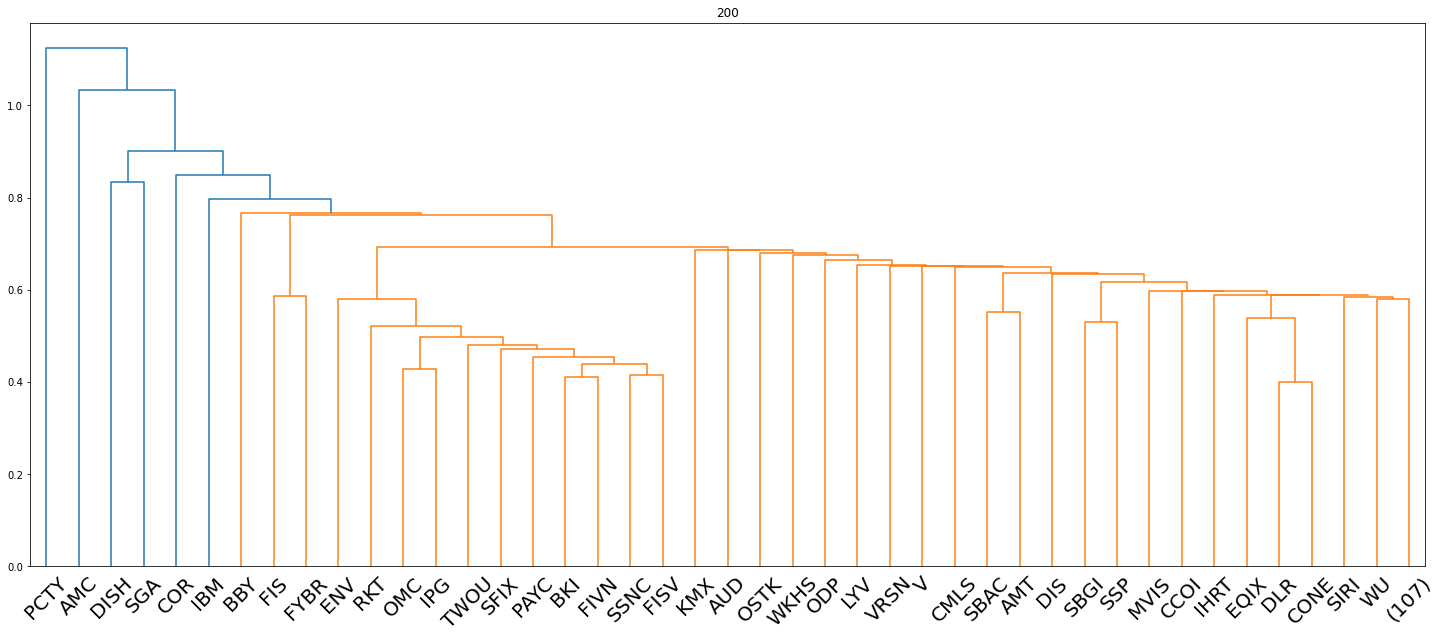

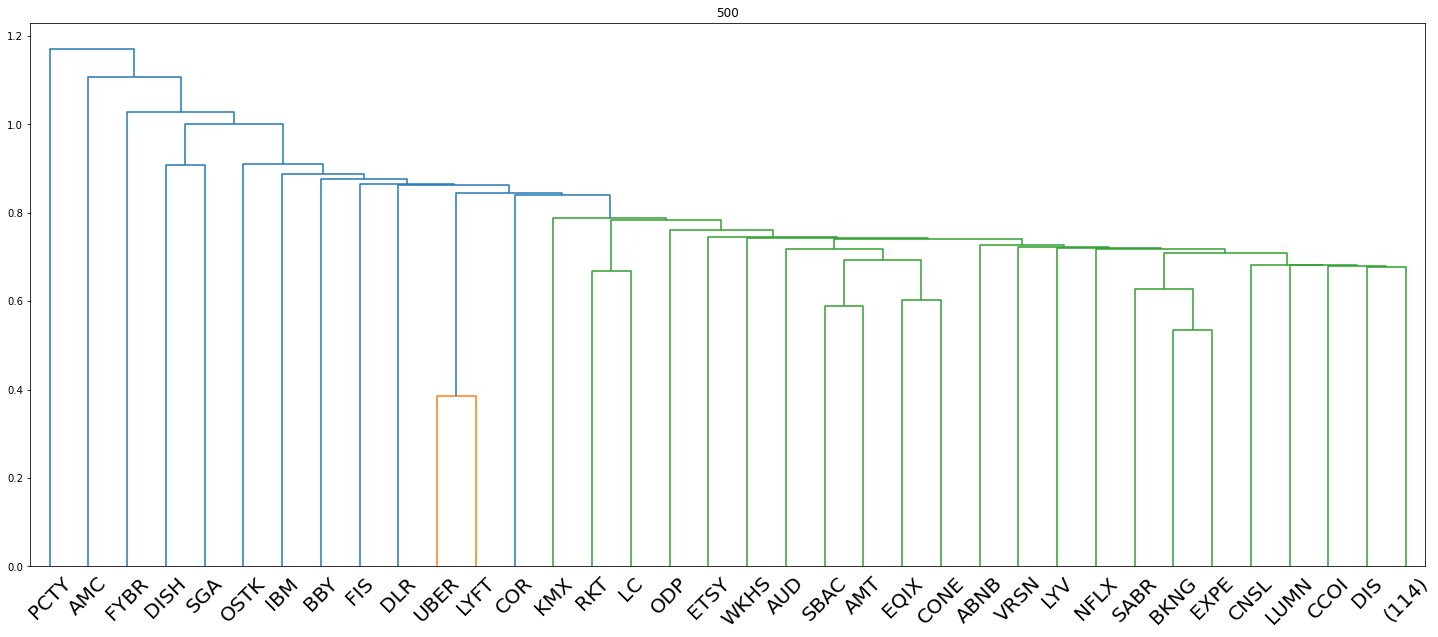

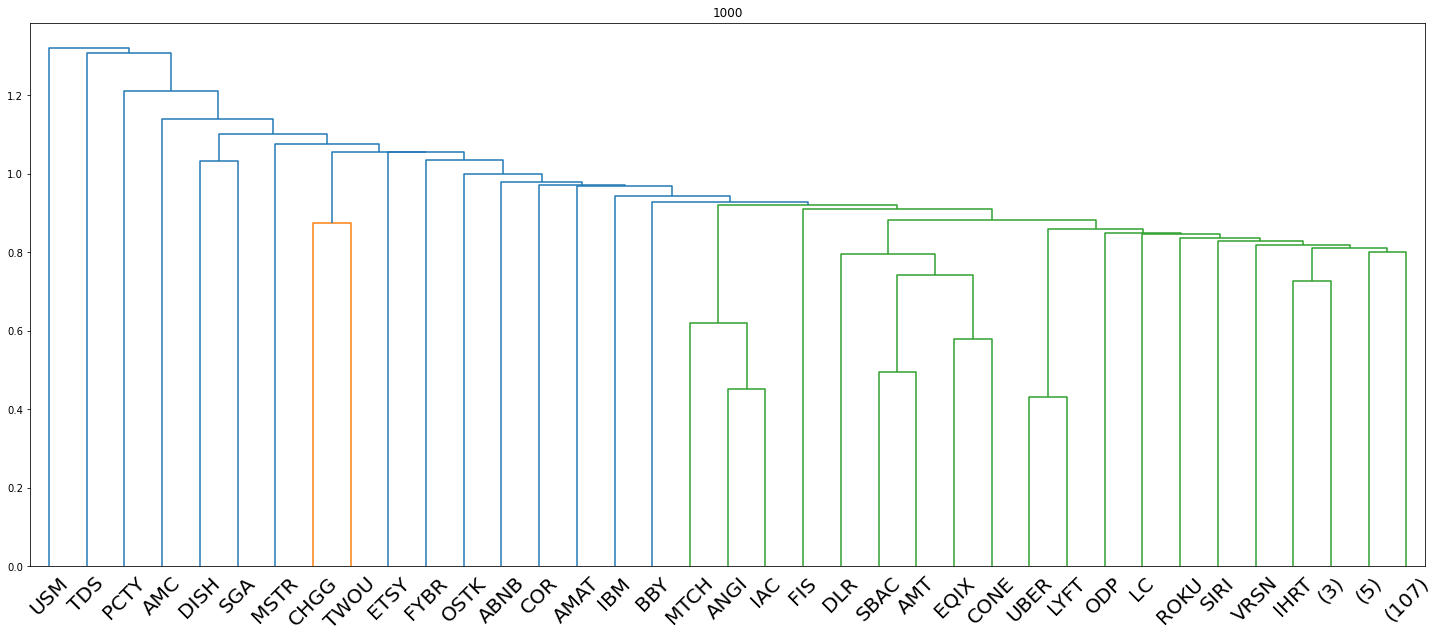

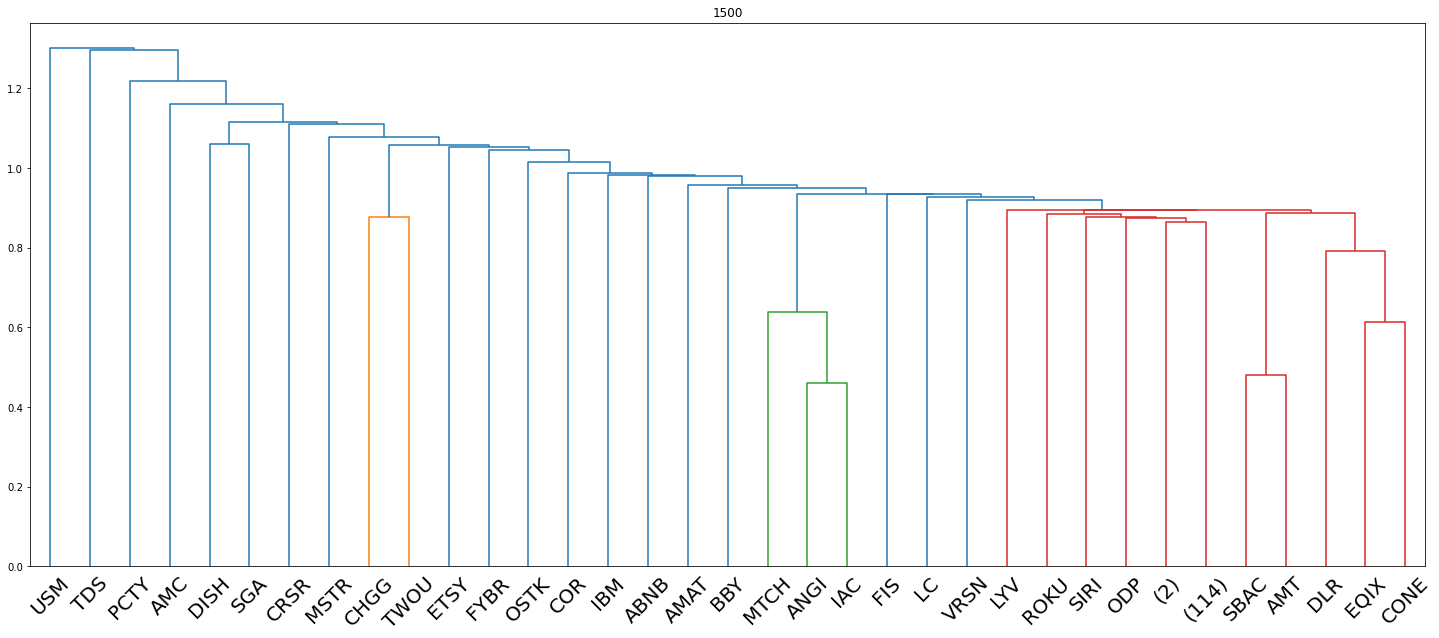

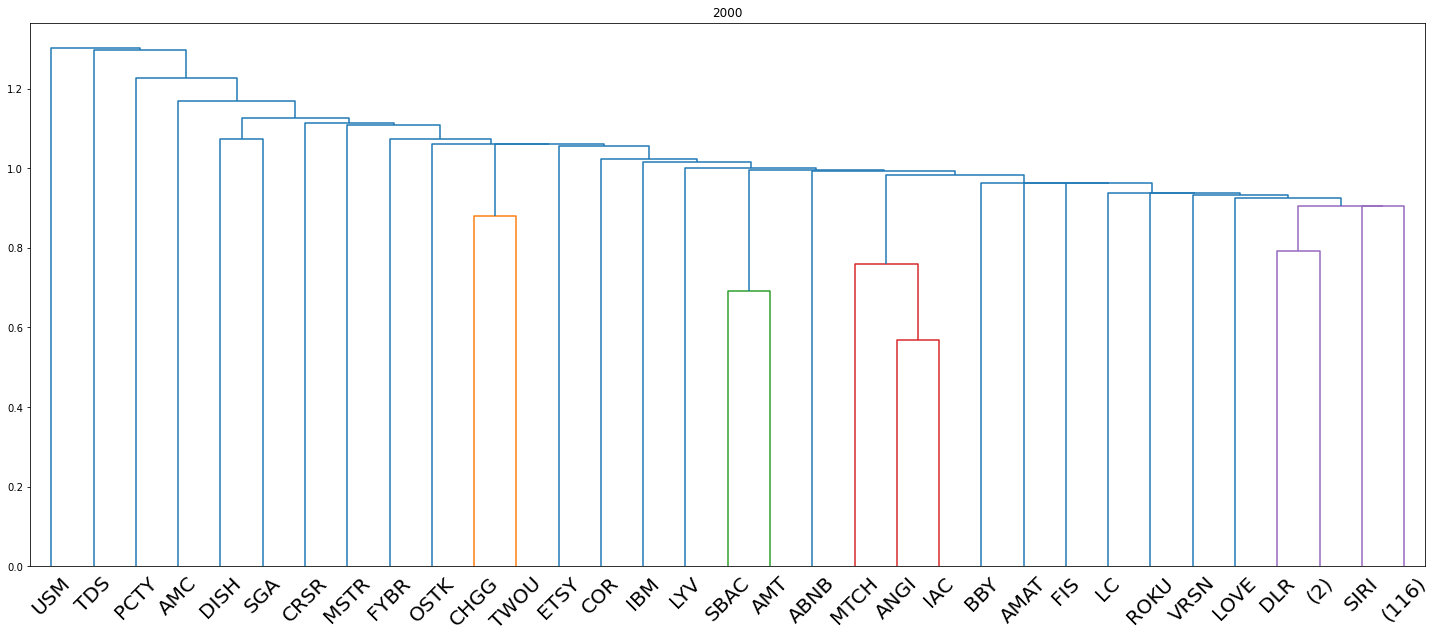

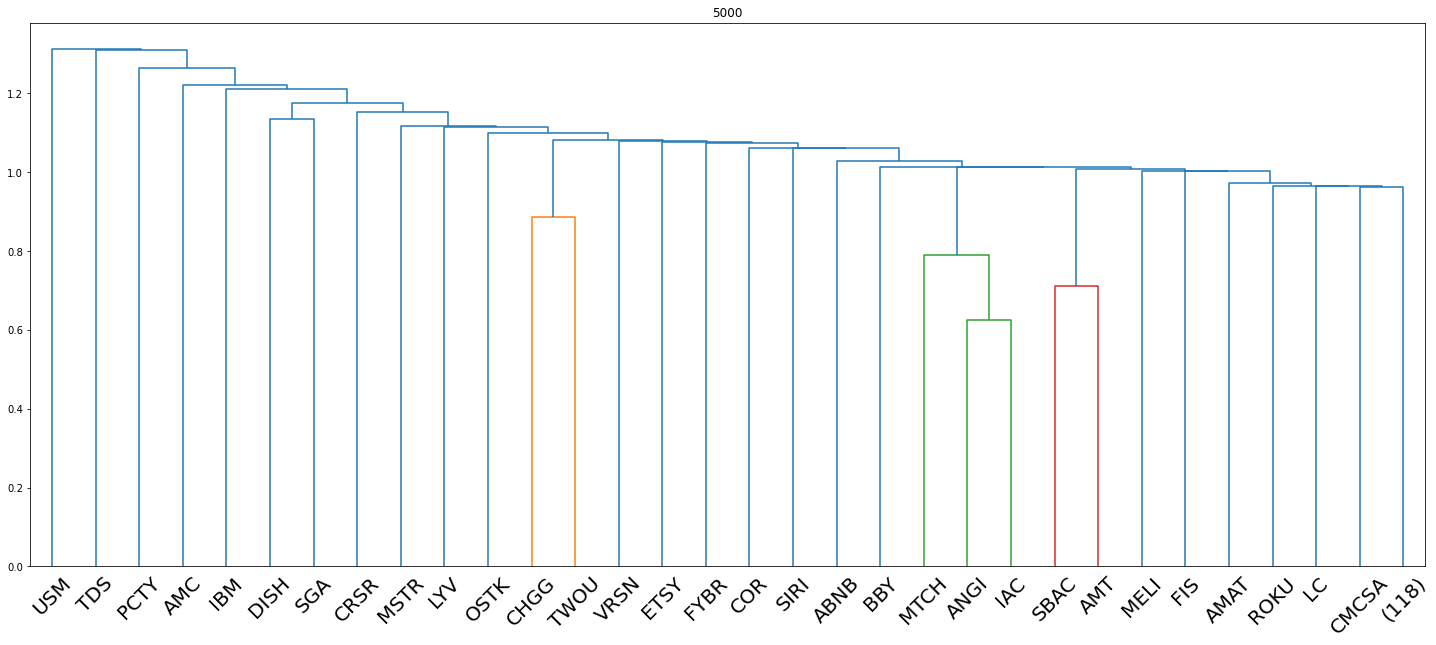

In [22]:
%%capture

groupings=pd.DataFrame(index=corpus.keys(),columns=engineers.keys())
fig,axes=plt.subplots(nrows=figsize=(45,15),ncols=5,nrows=2);
axes=axes.reshape(-1)
i=0
for max_ftr,engineer in engineers.items():
    X=engineer.transform(corpus.values())
    X_vect=pd.DataFrame.sparse.from_spmatrix(X)
    ax=axes[i]
    ax.set_title(max_ftr);
    dendrogram(
            linkage(X_vect),
            leaf_rotation=45.,
            leaf_font_size=20.,
            labels=list(corpus.keys()),
            p=25,
            truncate_mode='level'
            );
    Agg.fit(X.toarray())
    groupings[max_ftr]=Agg.labels_   
    i+=1

plt.savefig(image_path+'Dendograms/MaxFeatures.pdf',
            orientation='landscape',
            pad_inches=0.0,
            bbox_inches='tight',
            format='pdf'
           );

From the graphs above, we can deduce that when we allow for more features, groupings occur at a higher and higher level.  To formalize this intuition, lets collect the clustering distributions for each value of max-features.

In [23]:
distributions=pd.DataFrame(index=range(0,20),columns=engineers.keys())
for max_feature in engineers.keys():
    distributions[max_feature]=groupings[max_feature].value_counts()

And save out to excel for future manipulation/use.

In [ ]:
with pd.ExcelWriter(data_path+'Results/Different_Max_Features.xlsx') as writer:
    groupings.to_excel(writer,sheet_name='Individual')
    distributions.to_excel(writer,sheet-name='Collective')

### Min & Max DFs

What if we used different pair values for max and min df?

In [ ]:
corpus=corpus_2020
Agg=AgglomerativeClustering(n_clusters=20)

In [ ]:
engineers={}
for mx in range(75,100,5):
    for mn in range(0,11,2)
        parms={'max_df':mx/100,'max_features':1000,'min_df':mn/100}
        engineers[str(mn)+'_'+str(mx)]=create_extractor(corpus.values(),parms,'maxmin_'+str(mx)+'_'+str(mn))

In [ ]:
%%capture
groupings=pd.DataFrame(index=corpus.keys(),columns=engineers.keys())
fig,axes=plt.subplots(nrows=figsize=(45,25),ncols=5,nrows=5);
axes=axes.reshape(-1)
i=0
for df_range,engineer in engineers.items():
    X=engineer.transform(corpus.values())
    X_vect=pd.DataFrame.sparse.from_spmatrix(X)
    ax=axes[i]
    ax.set_title('Min_Max of '+df_range);
    dendrogram(
            linkage(X_vect),
            leaf_rotation=45.,
            leaf_font_size=20.,
            labels=list(corpus.keys()),
            p=25,
            truncate_mode='level'
            );
    Agg.fit(X.toarray())
    groupings[max_ftr]=Agg.labels_
    i+=1
    
plt.savefig(image_path+'Dendograms/DF_Ranges.pdf',
            orientation='landscape',
            pad_inches=0.0,
            bbox_inches='tight',
            format='pdf'
           );


Once again, lets calculate the distributions of these clusterings...

In [ ]:
distributions=pd.DataFrame(index=range(0,20),columns=engineers.keys())
for max_feature in engineers.keys():
    distributions[max_feature]=groupings[max_feature].value_counts()

...And save out all results:

In [ ]:
with pd.ExcelWriter(data_path+'Results/Different_DFRange.xlsx') as writer:
    groupings.to_excel(writer,sheet_name='Individual')
    distributions.to_excel(writer,sheet-name='Collective')

### Corpus Selection
Because we have a two-step process--engineering and clustering--it is not necessary, or possibly even advantageous, to train our engineer with the same corpus that we ultimately cluster.

To explore, lets create five engineers created from different corpa: those from the three year period of 2018-2020, and just 2019.  Then conduct the following clusterings: (1) the three-year corpus by (A) full and (B) three-year engineers; and (2) the 2019-corpus by (A) full, (B) three-year and (C) 2019 engineers. 

In [ ]:
corpus_3yr=collect_texts_years(['2020','2019','2018'])
parms={'max_df':0.99,'max_features':1000,'min_df':0.01}
engineer1=create_extractor(corpus_full.values(),parms,'Alltime')
engineer2=create_extractor(corpus_3yr.values(),parms,'3_Years')
engineer3=create_extractor(corpus_2019.values(),parms,'2019s')

In [ ]:
clusterer=AgglomerativeClustering(n_clusters=20)

groupings1=pd.DataFrame(index=corpus_3yr.keys(),columns=['All Years','3 Years'])
X1A=engineer1.transform(corpus_3yr.values())
X1B=engineer2.transform(corpus_3yr.values())
clusterer.fit(X1A.toarray())
groupings1['All Years']=clusterer.labels_
clusterer.fit(X1B.toarray())
groupings1['3 Years']=clusterer.labels_

groupings2=pd.DataFrame(index=corpus_2019.keys(),columns=['All Years','3 Years','2019'])
X2A=engineer1.transform(corpus_19.values())
X2B=engineer2.transform(corpus_19.values())
X2C=engineer3.transform(corpus_19.values())

clusterer.fit(X2A.toarray())
groupings2['All Years']=clusterer.labels_

clusterer.fit(X2B.toarray())
groupings2['3 Years']=clusterer.labels_

clusterer.fit(X2C.toarray())
groupings2['2019']=clusterer.labels_

In [ ]:
ith pd.ExcelWriter(data_path+'Results/Different_Dictionaries.xlsx') as writer:
    groupings1.to_excel(writer,sheet_name='Three Year')
    groupings2.to_excel(writer,sheet-name='2019')

## Clustering Methodology & Hyperparameters
For the second step, we have a number of clustering methods that have different uses and different parameters to adjust.  

In [24]:
corpus=corpus_2020
parms={'max_df':0.99,'max_features':1000,'min_df':0.01}
engineer=create_extractor(corpus_all.values(),parms)

### Different Cluster Values for K-Means

In [25]:
K3=KMeans(n_clusters=3)
K5=KMeans(n_clusters=5)
K8=KMeans(n_clusters=8)
K10=KMeans(n_clusters=10)
K15=KMeans(n_clusters=15)
K25=KMeans(n_clusters=25)
clusterers={'3':K3,'5':K5,'8':K8,'10':K10,'15':K15,'25':K25}

In [26]:
groupings=pd.DataFrame(index=corpus.keys(),columns=engineers.keys())
X=engineer.transform(corpus.values())
for n,clusterer in clusterers.items():
    clusterer.fit(X.toarray())
    groupings[n]=clusterer.labels_
groupings.to_excel(parent_path+'Data/Results/KNNs.xlsx')

### Affinity Propogation-Full Period

In [ ]:
parms={'max_df':0.99,'max_features':1000,'min_df':0.01}
engineer=create_extractor(corpus_full.values(),parms)

In [ ]:
Aff=AffinityPropagation(max_iter=5000,random_state=STATE)
X=engineer.transform(corpus_full.values())
Aff.fit(X.toarray())
Aff_Clusters=pd.DataFrame(zip(corpus.keys(),Aff.labels_),columns=['Ticker','Category'])
Aff_Clusters.to_excel(parent_path+'Data/Results/Affinity_Labels.xlsx')

In [ ]:
centers=Aff.cluster_centers_indices_.tolist()
Aff_Summary=Aff_Clusters.loc[centers]
Aff_Summary.set_index(['Category'],inplace=True)
Aff_Summary['Count']=Aff_Clusters.Category.value_counts()
Aff_Summary.to_excel(parent_path+'Data/Results/Affinity_Summary.xlsx')

### Affinity Propogation-Past Five Years, by Year

In [ ]:
parms={'max_df':0.99,'max_features':1000,'min_df':0.01}
engineer=create_extractor(corpus_all.values(),parms)
corpa=zip(['2020','2019','2018','2017','2016'],[corpus_2020,corpus_2019,corpus_2018,corpus_2017,corpus_2016])

In [ ]:
Aff=AffinityPropagation(max_iter=500,random_state=STATE)
for yr,corpus in corpa:
    X=engineer.transform(corpus.values())
    Aff.fit(X.toarray())
    Aff_Clusters=pd.DataFrame(zip(corpus.keys(),Aff.labels_),columns=['Ticker','Category'])
    Aff_Clusters.to_excel(parent_path+'Data/Results/Affinity_Labels_'+yr+'.xlsx')

    centers=Aff.cluster_centers_indices_.tolist()
    Aff_Summary=Aff_Clusters.loc[centers]
    Aff_Summary.set_index(['Category'],inplace=True)
    Aff_Summary['Count']=Aff_Clusters.Category.value_counts()
    Aff_Summary.to_excel(parent_path+'Data/Results/Affinity_Summary_'+yr+'.xlsx')

### Different Linkage Options for Agglomerative

In [27]:
links=['ward','complete','average','single']
groupings=pd.DataFrame(index=corpus.keys(),columns=links)
engineer=create_extractor(corpus.values(),parms)
X=engineer.transform(corpus.values())
XX=X.toarray()
for link in links:
    Agg=AgglomerativeClustering(n_clusters=20,linkage=link)
    Agg.fit(XX)
    groupings[link]=Agg.labels_
    
groupings.to_excel(parent_path+'Data/Results/Linkages.xlsx')

Final Clustering-Two Ways

Clustering w/ Agg.Prop...Done two ways.

In [39]:
five_years=['2020','2019','2018','2017','2016']
stocks=Filed[
            Filed['2020'] & 
            Filed['2019'] & 
            Filed['2018'] & 
            Filed['2017'] & 
            Filed['2016']
            ].index

Way 1: Cluster entire corpus simultaneously.

In [40]:
corpus_5yr=collect_texts(stocks,five_years)
ann_corpa=[collect_texts(stocks,[y]) for y in five_years]

In [41]:
parms={'max_df':0.99,'max_features':1000,'min_df':0.01}
engineer=create_extractor(full_corpus.values(),parms,'All_5yrs')
clusterer=AgglomerativeClustering(n_clusters=20)

In [42]:
X=engineer.transform(corpus.values())
clusterer.fit(X.toarray())

AgglomerativeClustering(n_clusters=20)

In [43]:
DF_All=pd.DataFrame(zip(clusterer.labels_,corpus_5yr.keys()),columns=['Group','Stock_Year'])
DF_All['Stock']=DF_All.Stock_Year.apply(lambda s:s.split('_')[0])
DF_All['Year']=DF_All.Stock_Year.apply(lambda s:s.split('_')[1])
DF_All.set_index(['Stock','Year'])
DF_All.to_excel(parent_path+'Data/Results/5Yr_Simultaneous.xlsx')

Way 2:  Split corpus into 5 parts (one for each year) prior to apply clustering.

In [44]:
DF_byYear=pd.DataFrame(columns=five_years,index=stocks)
parms={'max_df':0.99,'max_features':1000,'min_df':0.01}
engineer=create_extractor(corpus_5yr.values(),parms)

In [45]:
for y,corpus in zip(five_years,ann_corpa):
    X=engineer.transform(corpus.values())
    clusterer.fit(X.toarray())
    DF_byYear[y]=clusterer.labels_

In [46]:
DF_byYear.to_excel(parent_path+'Data/Results/5Yr_Annuals.xlsx')

Calculate Weightings to generate similarity matrix.

In [47]:
weights={'2020':0.3,'2019':0.2,'2018':0.2,'2017':0.15,'2016':0.15}
S=groups_to_similarity(DF_byYear,weights)
S.to_excel(parent_path+'Data/Results/5yr_Similarity.xlsx')

Second Methodology Except w/ 10 Year horizon

In [48]:
ten_years=['2020','2019','2018','2017','2016',
            '2015','2014','2013','2012','2011']
stocks=Filed[
            Filed['2020'] & 
            Filed['2019'] & 
            Filed['2018'] & 
            Filed['2017'] & 
            Filed['2016'] &
            Filed['2015'] & 
            Filed['2014'] & 
            Filed['2013'] & 
            Filed['2012'] & 
            Filed['2011']
            ].index
corpus_10yr=collect_texts(ten_years,stocks)
ann_corpa=[collect_texts(stocks,[y]) for y in ten_years]

In [49]:
parms={'max_df':0.99,'max_features':1000,'min_df':0.01}
engineer=create_extractor(full_corpus.values(),parms)
clusterer=AgglomerativeClustering(n_clusters=20)

In [50]:
DF_byYear=pd.DataFrame(columns=ten_years,index=stocks)
for y in ten_years:
    corpus=collect_texts(stocks,[y])
    X=engineer.transform(corpus.values())
    clusterer.fit(X.toarray())
    DF_byYear[y]=clusterer.labels_
DF_byYear.to_excel(parent_path+'Data/Results/10Yr_Annuals.xlsx')

In [51]:
weights={'2020':0.20,'2019':0.20,'2018':0.15,'2017':0.10,'2016':0.10,
         '2015':0.05,'2014':0.05,'2013':0.05,'2012':0.05,'2011':0.05}
S=groups_to_similarity(DF_byYear,weights)
S.to_excel(parent_path+'Data/Results/10yr_Similarity.xlsx')